# SLASH Slot Attention Shapeworld4 experiment test notebook

In [1]:
import time
import sys
sys.path.append('../')
sys.path.append('../../../')
sys.path.append('../../../SLASH/')
sys.path.append('../../../EinsumNetworks/src/')


#torch, numpy, ...
import torch
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import importlib
import matplotlib.pyplot as plt

#plt.style.use(["science"])  # Need SciencePlots pip package

import matplotlib
matplotlib.rcParams.update(
    {
        "font.family": "serif",
        "text.usetex": False,
    }
)


import utils
import ap_utils
import os

from slash import SLASH
from dataGen import get_loader, get_data_and_object_list, SHAPEWORLD4
from tqdm.notebook import tqdm

from einsum_wrapper import EiNet
from slot_attention_module import SlotAttention_model



A detection is considered a **true positive** if the discrete predicted properties (obtained with an argmax) exactly match the ground truth. 
- This excludes predicting the correct background object
- If we predict two blue spheres but only have one blue sphere as our ground truth we get one true positve and one false positve

A detection is considered a **false positive** if the discrete predicted properties (obtained with an argmax) do not exactly match the ground truth.
- If we predict an object with either shape background or color black this is considered a false positive.

A detection is considered a **true negative** if the background is predicted correctly.
- We have one background prediction for each sample
- If we predict two background objects we would get one true negative and one false negative




In [2]:
#MODEL = "most_probable_with_slot_with_lr_decay"
MODEL = "shapeworld4"
#data/one_to_one_pretrained_test_2/slash_slot_models.pt
class_count = 3
num_slots = 4
bg_encoded = False


model_path = "data/"+MODEL+"/slash_slot_models.pt" 
models = torch.load(model_path)

exp_dict = models['exp_dict']
print(exp_dict)

print(models.keys())
program = models['program']

#setup new SLASH program given the network parameters
if exp_dict['structure'] == 'poon-domingos':
    exp_dict['depth'] = None
    exp_dict['num_repetitions'] = None
    print("using poon-domingos")

elif exp_dict['structure'] == 'binary-trees':
    exp_dict['pd_num_pieces'] = None
    print("using binary-trees")


#NETWORKS

#color network
color_net = EiNet(structure = exp_dict['structure'],
    pd_num_pieces = exp_dict['pd_num_pieces'],
    depth = exp_dict['depth'],
    num_repetitions = exp_dict['num_repetitions'],
    num_var = 32,
    class_count=9,
    pd_width=8,pd_height=4,
    use_em= False)

#shape network
shape_net = EiNet(structure = exp_dict['structure'],
    pd_num_pieces = exp_dict['pd_num_pieces'],
    depth = exp_dict['depth'],
    num_repetitions = exp_dict['num_repetitions'],
    num_var = 32,
    class_count=4,
    pd_width=8,pd_height=4,
    use_em= False)

#shade network
shade_net = EiNet(structure = exp_dict['structure'],
    pd_num_pieces = exp_dict['pd_num_pieces'],
    depth = exp_dict['depth'],
    num_repetitions = exp_dict['num_repetitions'],
    num_var = 32,
    class_count=3,
    pd_width=8,pd_height=4,
    use_em= False)

#size network
size_net = EiNet(structure = exp_dict['structure'],
    pd_num_pieces = exp_dict['pd_num_pieces'],
    depth = exp_dict['depth'],
    num_repetitions = exp_dict['num_repetitions'],
    num_var = 32,
    class_count=3,
    pd_width=8,pd_height=4,
    use_em= False)
    
#create the Slot Attention network
slot_net = SlotAttention_model(n_slots=num_slots, n_iters=3, n_attr=18,
                                encoder_hidden_channels=32, attention_hidden_channels=64,
                                decoder_hidden_channels=32, decoder_initial_size=(32, 32)).to(device='cuda')# was 32*32 and 128

"""
slot_net_obj_discovery = obj_discovery.SlotAttention_model(n_slots=3, n_iters=3, n_attr=18,
                                encoder_hidden_channels=32, attention_hidden_channels=64,
                                decoder_hidden_channels=32, decoder_initial_size=(32, 32))#.to(device='cuda')# was 32*32 and 128
slot_net_obj_discovery.eval()
"""

#load all model parts
shape_net.load_state_dict(models['shape_net'])
color_net.load_state_dict(models['color_net'])
shade_net.load_state_dict(models['shade_net'])
size_net.load_state_dict(models['size_net'])

slot_net.load_state_dict(models['slot_net'])




s_params = list(shape_net.parameters()) + list(slot_net.parameters())
c_params = list(color_net.parameters()) + list(slot_net.parameters())


#create the SLASH Program
nnMapping = {'color': color_net,
                 'shape':shape_net,
                 'shade':shade_net,
                 'size':size_net}
optimizers = {'color': torch.optim.Adam(c_params, lr=exp_dict['lr'], eps=1e-7),
              'shape':torch.optim.Adam(s_params, lr=exp_dict['lr'], eps=1e-7)}
SLASHobj = SLASH(program, nnMapping, optimizers)

{'structure': 'poon-domingos', 'pd_num_pieces': [4], 'lr': 0.01, 'bs': 512, 'epochs': 1100, 'lr_warmup_steps': 8, 'lr_decay_steps': 368, 'start_date': '19-01-2022', 'resume': True, 'credentials': 'DO', 'seed': 1, 'p_num': 8, 'explanation': 'Running the whole SlotAttention+Slash pipeline using poon-domingos as SPN structure learner.', 'depth': None, 'num_repetitions': None}
dict_keys(['shape_net', 'color_net', 'shade_net', 'size_net', 'slot_net', 'resume', 'test_ll_list', 'test_ap_list', 'loss_list', 'test_metric_list', 'lr_list', 'num_params', 'time', 'exp_dict', 'program'])
using poon-domingos
P(C) is learnable.
P(C) is tensor([-2.1972, -2.1972, -2.1972, -2.1972, -2.1972, -2.1972, -2.1972, -2.1972,
        -2.1972], device='cuda:0', requires_grad=True)
train SPN with EM: False
P(C) is learnable.
P(C) is tensor([-1.3863, -1.3863, -1.3863, -1.3863], device='cuda:0',
       grad_fn=<LogBackward>)
train SPN with EM: False
P(C) is learnable.
P(C) is tensor([-1.0986, -1.0986, -1.0986], devi

In [3]:
#self.mvpp['program'], self.mvpp['program_pr'], self.mvpp['program_asp'] = self.parse(query='')

print(SLASHobj.mvpp['program_pr'])

print("\n\n")
print(SLASHobj.mvpp['program_asp'])

@0.0 size(0,1, s1, small); @0.0 size(0,1, s1, big); @0.0 size(0,1, s1, bg).
@0.0 size(0,1, s2, small); @0.0 size(0,1, s2, big); @0.0 size(0,1, s2, bg).
@0.0 size(0,1, s3, small); @0.0 size(0,1, s3, big); @0.0 size(0,1, s3, bg).
@0.0 size(0,1, s4, small); @0.0 size(0,1, s4, big); @0.0 size(0,1, s4, bg).
@0.0 shape(0,1, s1, circle); @0.0 shape(0,1, s1, triangle); @0.0 shape(0,1, s1, square); @0.0 shape(0,1, s1, bg).
@0.0 shape(0,1, s2, circle); @0.0 shape(0,1, s2, triangle); @0.0 shape(0,1, s2, square); @0.0 shape(0,1, s2, bg).
@0.0 shape(0,1, s3, circle); @0.0 shape(0,1, s3, triangle); @0.0 shape(0,1, s3, square); @0.0 shape(0,1, s3, bg).
@0.0 shape(0,1, s4, circle); @0.0 shape(0,1, s4, triangle); @0.0 shape(0,1, s4, square); @0.0 shape(0,1, s4, bg).
@0.0 color(0,1, s1, red); @0.0 color(0,1, s1, blue); @0.0 color(0,1, s1, green); @0.0 color(0,1, s1, gray); @0.0 color(0,1, s1, brown); @0.0 color(0,1, s1, magenta); @0.0 color(0,1, s1, cyan); @0.0 color(0,1, s1, yellow); @0.0 color(0,1, s1

# Model predictions

In [4]:
dataList, queryList, objList = get_data_and_object_list(SHAPEWORLD4('../../data/shapeworld4/',"val"), 1, shuffle=False)
print(len(dataList), len(queryList))

inference, out = SLASHobj.forward_slot_attention_pipeline(slot_net=slot_net, data_batch= dataList[5])



100%|██████████| 5/5 [00:04<00:00,  1.20it/s]

5000 5000


In [5]:
def interpret_inference(inference,print_query =True):

    
    inference_list = []
    
    """
    pc(color(1,X),[red, blue, green, gray, brown, magenta, cyan, yellow, black]) :- slot(X).
    pc(shape(1,X),[circle, triangle, square, bg]) :- slot(X).
    pc(shade(1,X),[bright, dark, bg]) :- slot(X).
    pc(size(1,X),[small, big, bg]) :- slot(X)."""
    
    
    for slot in inference:
        shape = inference[slot]['shape']
        color = inference[slot]['color']
        shade = inference[slot]['shade']
        size = inference[slot]['size']

        sid = torch.argmax(shape)
        cid = torch.argmax(color)
        hid = torch.argmax(shade)
        xid = torch.argmax(size)
        
        s=''
        c=''
        h=''
        x=''
        
        #print(sid, cid)
        if cid == 0:
            c= 'red'
        elif cid == 1:
            c= 'blue'
        elif cid == 2:
            c= 'green'
        elif cid == 3:
            c= 'gray'
        elif cid == 4:
            c= 'brown'
        elif cid == 5:
            c= 'magenta'            
        elif cid == 6:
            c= 'cyan'            
        elif cid == 7:
            c= 'yellow'            
        elif cid == 8:
            c= 'black'
            
        if sid == 0:
            s='circle'
        elif sid == 1:
            s='triangle'
        elif sid == 2:
            s='square'
        elif sid == 3:
            s='bg'    
      
                    
        if hid == 0:
            h='bright'
        elif hid == 1:
            h='dark'
        elif hid == 2:
            h='bg'
             
                    
        if xid == 0:
            x='small'
        elif xid == 1:
            x='big'
        elif xid == 2:
            x='bg'
        
        if print_query:
            print("there is a {} {} {} {} in the image.".format(x, h, c, s))
        
        #if c != 'black' and s != 'bg': 
        inference_list.append([c, s])
    
    return inference_list

### Model tell us what we see in the image! 

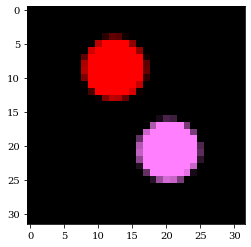

trained with query string:
:- not object(o1,red,circle,bright,big). :- not object(o2,magenta,circle,dark,big). :- not object(o3,black,bg, bg, bg). :- not object(o4,black,bg, bg, bg). 
The model says:
there is a bg bg black bg in the image.
there is a bg bg black bg in the image.
there is a big dark magenta circle in the image.
there is a big bright red circle in the image.

with probabilities:
   red,    blue,  green, gray,  brown,magenta,cyan, yellow, black, circle, triangle, square, bg
s0 [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 1.000] [0.000, 0.000, 0.000, 1.000]
s1 [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 1.000] [0.000, 0.000, 0.000, 1.000]
s2 [0.003, 0.001, 0.000, 0.000, 0.000, 0.996, 0.000, 0.000, 0.000] [0.998, 0.001, 0.000, 0.000]
s3 [0.997, 0.000, 0.000, 0.000, 0.000, 0.002, 0.000, 0.000, 0.000] [1.000, 0.000, 0.000, 0.000]
   bright, dark,  bg,     small, big,   bg
s0 [0.000, 0.000, 1.000] [0.000, 0.000, 1.000]
s1 [0.000, 0.000, 1.000] [0.000, 

In [6]:
idx = int(np.random.rand()* len(dataList))

idx = 4156


#plot the image
img = np.einsum("abc->bca",dataList[idx]['im'].cpu().numpy().squeeze())

#with plt.style.context('dark_background'):
plt.imshow((img+1)/2)


plt.show()


print("trained with query string:")
print(queryList[idx])


#get the predictions of what is in the image
inference, out = SLASHobj.forward_slot_attention_pipeline(slot_net=slot_net, data_batch= dataList[idx])

print("The model says:")
interpret_inference(inference)


print("\nwith probabilities:")

print("   red,    blue,  green, gray,  brown,magenta,cyan, yellow, black, circle, triangle, square, bg")

for slot in inference.keys():
    
    color = ("["+', '.join(['%.3f']*9)+"]") % tuple(inference[slot]['color'].cpu().numpy()[0])
    shape = ("["+', '.join(['%.3f']*4)+"]") % tuple(inference[slot]['shape'].cpu().numpy()[0])
    print(slot,color,shape)
    
print("   bright, dark,  bg,     small, big,   bg")

for slot in inference.keys():
    shade = ("["+', '.join(['%.3f']*3)+"]") % tuple(inference[slot]['shade'].cpu().numpy()[0])
    size = ("["+', '.join(['%.3f']*3)+"]") % tuple(inference[slot]['size'].cpu().numpy()[0])
    print(slot,shade,size)
    
 
print("\n Our GT is:\n",queryList[idx])



### Average precision values

In [7]:
dataListArray = np.array(dataList)
inference, _ = SLASHobj.forward_slot_attention_pipeline(slot_net=slot_net, data_batch= dataListArray[:])


target = np.array(objList)

#compute the average precision, tp, fp, tn for color+shape, color, shape
pred = ap_utils.inference_map_to_array(inference).cpu().numpy()



print(pred.shape,target.shape)

ap, true_positives, false_positives, true_negatives, correctly_classified = ap_utils.average_precision(pred, target,-1, "SHAPEWORLD4")
print("avg precision ",ap, "tp", true_positives, "fp", false_positives, "tn", true_negatives, "correctly classified",correctly_classified)


#color
pred_c = ap_utils.inference_map_to_array(inference, only_color=True).cpu().numpy()
ap_c, true_positives_c, false_positives_c, true_negatives_c, correctly_classified_c  = ap_utils.average_precision(pred, target,-1, "SHAPEWORLD4", only_color = True)
print("avg precision color",ap_c, "tp", true_positives_c, "fp", false_positives_c, "tn", true_negatives_c, "correctly classified",correctly_classified_c)

#shape              
pred_s = ap_utils.inference_map_to_array(inference, only_shape=True).cpu().numpy()
ap_s, true_positives_s, false_positives_s, true_negatives_s, correctly_classified_s= ap_utils.average_precision(pred_s, target,-1, "SHAPEWORLD4", only_shape = True)
print("avg precision shape",ap_s, "tp", true_positives_s, "fp", false_positives_s, "tn", true_negatives_s, "correctly classified",correctly_classified_s)

#shade              
pred_h = ap_utils.inference_map_to_array(inference, only_shade=True).cpu().numpy()
ap_h, true_positives_h, false_positives_h, true_negatives_h, correctly_classified_h= ap_utils.average_precision(pred_h, target,-1, "SHAPEWORLD4", only_shade = True)
print("avg precision shade",ap_h, "tp", true_positives_h, "fp", false_positives_h, "tn", true_negatives_h, "correctly classified",correctly_classified_h)

#shape              
pred_x = ap_utils.inference_map_to_array(inference, only_size=True).cpu().numpy()
ap_x, true_positives_x, false_positives_x, true_negatives_x, correctly_classified_x= ap_utils.average_precision(pred_x, target,-1, "SHAPEWORLD4", only_size = True)
print("avg precision size",ap_x, "tp", true_positives_x, "fp", false_positives_x, "tn", true_negatives_x, "correctly classified",correctly_classified_x)

(5000, 4, 20) (5000, 4, 20)


/workspaces/slash/src/experiments/slash_attention/shapeworld4/../ap_utils.py:308: RuntimeWarning: invalid value encountered in true_divide
  precision_array = np.divide(accumulated_tp, (accumulated_fp + accumulated_tp))


avg precision  0.9481931144949272 tp 11999.0 fp 635.0 tn 7366.0 correctly classified 4467
avg precision color 0.966643391725615 tp 12228.0 fp 407.0 tn 7365.0 correctly classified 4613
avg precision shape 0.9863722443968648 tp 12466.0 fp 168.0 tn 7366.0 correctly classified 4833
avg precision shade 0.9796051482559278 tp 12383.0 fp 251.0 tn 7366.0 correctly classified 4749
avg precision size 0.9933776274758905 tp 12552.0 fp 82.0 tn 7366.0 correctly classified 4920


## Log Likelihoods
circle 0, triangle 1, square 2
red 0, blue 1, green 2
            

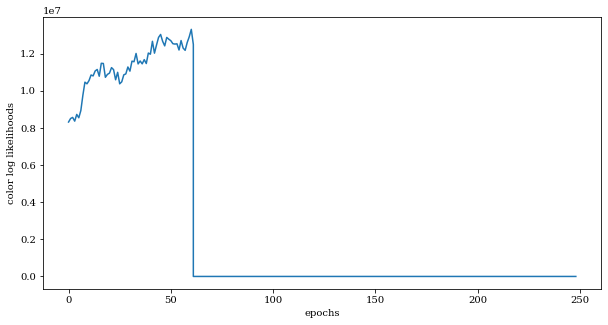

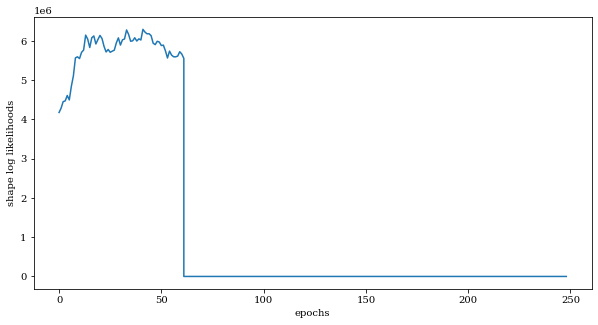

In [8]:
test_ll_list = models['test_ll_list']

temp= np.zeros((len(test_ll_list), 3))


for i, ll in enumerate(test_ll_list):
    temp[i,0] = ll[1]
    temp[i,1] = ll[0][0]
    temp[i,2] = ll[0][1]

x = temp.shape[0]
x= 250
sign = -1

    
fig = plt.figure(figsize=(10,5))    
plt.plot(temp[:x,0], sign*temp[:x,1], label="c")
plt.xlabel("epochs")
plt.ylabel("color log likelihoods")
plt.show()

fig = plt.figure(figsize=(10,5))    
plt.plot(temp[:x,0], sign*temp[:x,2])
plt.xlabel("epochs")
plt.ylabel("shape log likelihoods")
plt.show()

plt.show()



# Average Precision plots

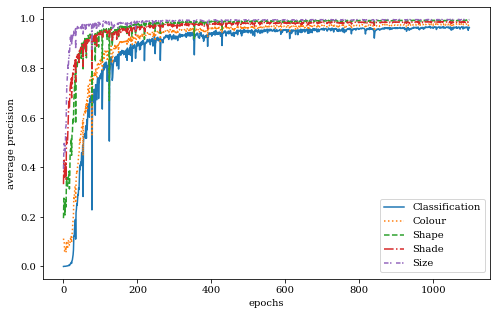

0.9702488049517893
[0.96710233 0.96620244 0.96404978 0.96294551 0.96643043 0.96444771
 0.9534334  0.96215071 0.96628904 0.96410573]


In [15]:
test_ap_list = models['test_ap_list']
test_ap_list = np.array(test_ap_list)


x= 1100


fig, ax = plt.subplots(1, figsize=(8,5))


ax.set_xlabel("epochs")
ax.set_ylabel("average precision")

#ap, ap_c, ap_s, ap_h, ap_x, e

ax.plot(test_ap_list[:x,5], test_ap_list[:x,0], label="Classification", linestyle='solid')
ax.plot(test_ap_list[:x,5], test_ap_list[:x,1], label="Colour", linestyle='dotted')
ax.plot(test_ap_list[:x,5], test_ap_list[:x,2], label="Shape", linestyle='dashed')
ax.plot(test_ap_list[:x,5], test_ap_list[:x,3], label="Shade", linestyle='dashdot')
ax.plot(test_ap_list[:x,5], test_ap_list[:x,4], label="Size", linestyle=(0,(3,1,1,3)))


directory = os.path.dirname("plots/")
try:
    os.stat(directory)
except:
    os.mkdir(directory)
fig.legend(loc='lower right', bbox_to_anchor=(0.5, 0.13, 0.4, 0.2))
fig.savefig('plots/ap_shapeworld4.png', format="png")

plt.show()


print(np.max(test_ap_list[:x,0]))
print(test_ap_list[x-10:x,0])

# Loss

[ 0.52420235  0.5109423   0.48606977 ...  3.6685512  -0.13950188
 -0.00413099]


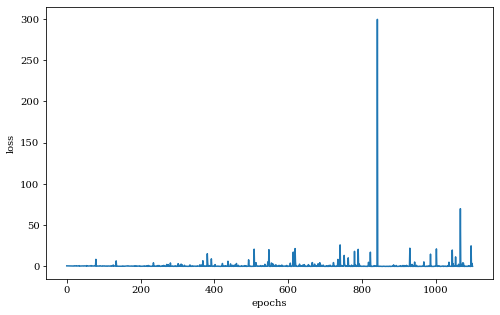

In [10]:
fig, ax = plt.subplots(1, figsize=(8,5))
loss_list = np.array(models['loss_list'])
ax.plot(loss_list)
print(loss_list)
ax.set_xlabel("epochs")
ax.set_ylabel("loss")
fig.savefig('plots/loss_shapeworld4.svg', format="svg")

### lr rates for slot attention module

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

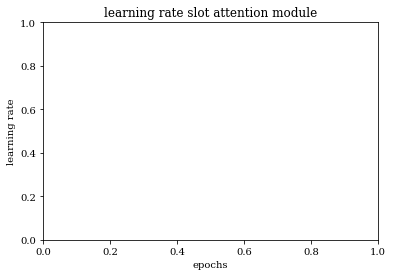

In [11]:
lr_list = np.array( models['lr_list'])
epochs = lr_list[:,1]
lr=np.stack(lr_list[:,0])

fig1, ax1 = plt.subplots()


#fig = plt.figure()  
ax1.set_title("learning rate slot attention module")
ax1.set_ylabel("learning rate")
ax1.set_xlabel("epochs")


ax1.plot(epochs, lr[:,1])

fig1.savefig('plots/learning_rate.svg', format="svg")
plt.show()


# OLD 


# Model comparison

### Average Precision


FileNotFoundError: [Errno 2] No such file or directory: 'data/most_prob_pd_endtoend/slash_slot_models.pt'

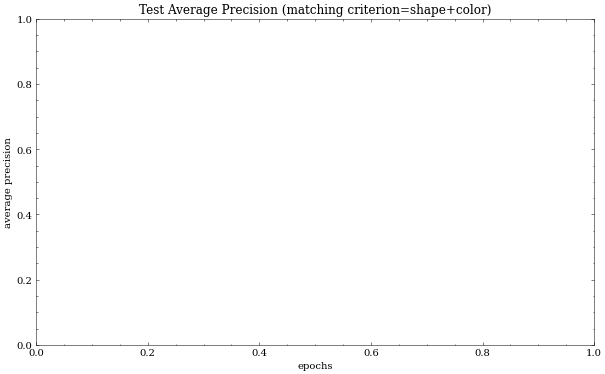

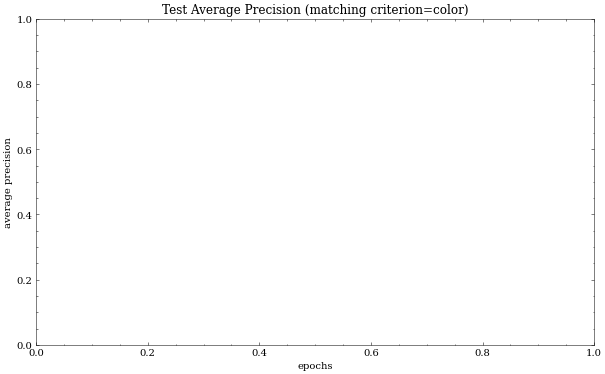

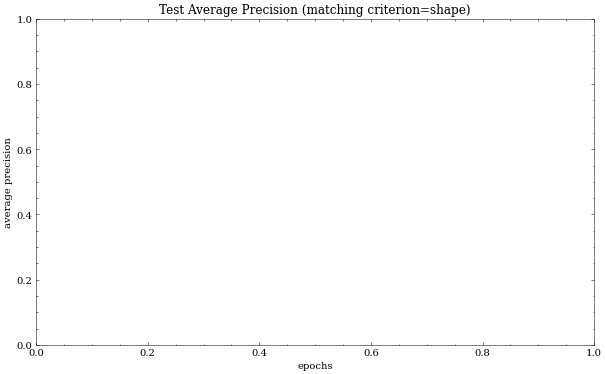

In [ ]:
model_paths = ["most_prob_pd_endtoend", "most_prob_bt_endtoend", "most_prob_pd_pretrained" , "most_prob_bt_pretrained"]



fig1, ax1 = plt.subplots(figsize=(10,6))
fig2, ax2 = plt.subplots(figsize=(10,6))
fig3, ax3 = plt.subplots(figsize=(10,6))

#fig = plt.figure()  
ax1.set_title("Test Average Precision (matching criterion=shape+color)")
ax1.set_ylabel("average precision")
ax1.set_xlabel("epochs")
ax2.set_title("Test Average Precision (matching criterion=color)")
ax2.set_ylabel("average precision")
ax2.set_xlabel("epochs")
ax3.set_title("Test Average Precision (matching criterion=shape)")
ax3.set_ylabel("average precision")
ax3.set_xlabel("epochs")


for mp in model_paths:
    model_path = "data/"+mp+"/slash_slot_models.pt" 
    models = torch.load(model_path)

    test_ap_list = models['test_ap_list']
    
    print(models['time'][0], mp)
    test_ap_list= np.array(test_ap_list)
    
    style="-"
    if models['exp_dict']['structure'] == 'poon-domingos':
        style="--"
    #print(test_ap_list.shape)
    x= 350


    ax1.plot(test_ap_list[:x,3], test_ap_list[:x,0],style, label=mp)    
    ax2.plot(test_ap_list[:x,3], test_ap_list[:x,1],style, label=mp)    
    ax3.plot(test_ap_list[:x,3], test_ap_list[:x,2],style, label=mp)    

    ax1.legend()
    ax2.legend()
    ax3.legend()

    fig1.savefig('plots/ap.svg', format="svg")
    fig2.savefig('plots/ap_color.svg', format="svg")
    fig3.savefig('plots/ap_shape.svg', format="svg")

    
plt.show()

In [ ]:
### log likelihoods

In [ ]:
model_paths = ["most_prob_pd_endtoend", "most_prob_bt_endtoend", "most_prob_pd_pretrained" , "most_prob_bt_pretrained"]



fig1, ax1 = plt.subplots(figsize=(10,6))
fig2, ax2 = plt.subplots(figsize=(10,6))
fig3, ax3 = plt.subplots(figsize=(10,6))

#fig = plt.figure()  
ax1.set_title("Test Average Precision (matching criterion=shape+color)")
ax1.set_ylabel("average precision")
ax1.set_xlabel("epochs")
ax2.set_title("Test Average Precision (matching criterion=color)")
ax2.set_ylabel("average precision")
ax2.set_xlabel("epochs")
ax3.set_title("Test Average Precision (matching criterion=shape)")
ax3.set_ylabel("average precision")
ax3.set_xlabel("epochs")


for mp in model_paths:
    model_path = "data/"+mp+"/slash_slot_models.pt" 
    models = torch.load(model_path)

    test_ap_list = models['test_ap_list']
    test_ap_list= np.array(test_ap_list)
    
    style="-"
    if models['exp_dict']['structure'] == 'poon-domingos':
        style="--"
    print(test_ap_list.shape)
    x= 350


    ax1.plot(test_ap_list[:x,3], test_ap_list[:x,0],style, label=mp)    
    ax2.plot(test_ap_list[:x,3], test_ap_list[:x,1],style, label=mp)    
    ax3.plot(test_ap_list[:x,3], test_ap_list[:x,2],style, label=mp)    

    ax1.legend()
    ax2.legend()
    ax3.legend()
plt.show()

# true positives

In [ ]:
"""
test_metric_list.append([true_positives, false_positives, true_negatives,correctly_classified,
                         true_positives_c, false_positives_c, true_negatives_c, correctly_classified_c,
                         true_positives_s, false_positives_s, true_negatives_s, correctly_classified_s])
"""

model_path = "data/most_prob_pd_endtoend/slash_slot_models.pt" 
models = torch.load(model_path)

print(models.keys())


test_metric_list = np.array(models['test_metric_list'])

correctly_classified =  test_metric_list[:350,3]
correctly_classified_color =  test_metric_list[:350,7]
correctly_classified_shape =  test_metric_list[:350,11]



fig1, ax1 = plt.subplots(figsize=(10,6))
ax1.set_title("Number of correctly classified samples on test set (5000 samples)")
ax1.set_ylabel("# correctly classified samples")
ax1.set_xlabel("epochs")

ax1.plot(correctly_classified,style, label="color+shape")
ax1.plot(np.argmax(correctly_classified), np.max(correctly_classified), 'r*')

ax1.plot(correctly_classified_color,style, label="color")
ax1.plot(np.argmax(correctly_classified_color), np.max(correctly_classified_color), 'r*')

ax1.plot(correctly_classified_shape, style, label="shape")
ax1.plot(np.argmax(correctly_classified_shape), np.max(correctly_classified_shape), 'r*')


ax1.legend()


fig1.savefig('plots/correctly_classified.svg', format="svg")


print(max_value, max_index)
plt.plot()